# Exercise 6 - Reinforcement Learning

In [1]:
! pip install swig
! pip install gymnasium[box2d]

In [2]:
# ENV. DISTRIBUTION MODE HARD EASY
GAMMA_ = 0.999
LAMBDA_ = 0.95
TIMES_PER_ROLLOUT = 256
EPOCHS_PER_ROLLOUT = 3
MINIBATCHES_PER_EPOCH = 8
ENTROPY_BONUS_KH = .01
PPO_CLIP_RANGE = .2
REWARD_NORMALIZATION = True
LEARNING_RATE = 5e-4 # TUNE ACCORDING TO ARCHITECTURE
WORKERS_EASY = 1
WORKERS_HARD = 4
ENVIRONMENTS_PER_WORKER = 64
TOTAL_TIMESTEPS_EASY= 25e6
# TOTAL_TIMESTEPS_HARD = 200e6
LSTM = False
FRAME_STACK = False

# Gymnasium implementation of PPO - with debug graphs

cpu


/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/Final_Recorded_Videos2 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode 20 	 Avg length: 92 	 Avg reward: -157


<ipython-input-3-179498993503>:99: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  states = torch.FloatTensor(memory.states).to(device)


Episode 40 	 Avg length: 89 	 Avg reward: -197
Episode 60 	 Avg length: 85 	 Avg reward: -183
Episode 80 	 Avg length: 94 	 Avg reward: -210
Episode 100 	 Avg length: 95 	 Avg reward: -147
Episode 120 	 Avg length: 96 	 Avg reward: -175
Episode 140 	 Avg length: 101 	 Avg reward: -117
Episode 160 	 Avg length: 104 	 Avg reward: -143
Episode 180 	 Avg length: 98 	 Avg reward: -202
Episode 200 	 Avg length: 109 	 Avg reward: -182
Episode 220 	 Avg length: 98 	 Avg reward: -173
Episode 240 	 Avg length: 101 	 Avg reward: -130
Episode 260 	 Avg length: 116 	 Avg reward: -157
Episode 280 	 Avg length: 109 	 Avg reward: -171
Episode 300 	 Avg length: 119 	 Avg reward: -168
Episode 320 	 Avg length: 119 	 Avg reward: -160
Episode 340 	 Avg length: 122 	 Avg reward: -143
Episode 360 	 Avg length: 115 	 Avg reward: -158
Episode 380 	 Avg length: 138 	 Avg reward: -150
Episode 400 	 Avg length: 140 	 Avg reward: -148
Episode 420 	 Avg length: 140 	 Avg reward: -135
Episode 440 	 Avg length: 159 

Moviepy - Done !
Moviepy - video ready /content/Final_Recorded_Videos2/video-episode-797.mp4
Videos saved.
Overall average length: 170.756
Overall average reward: -92.23384626367306


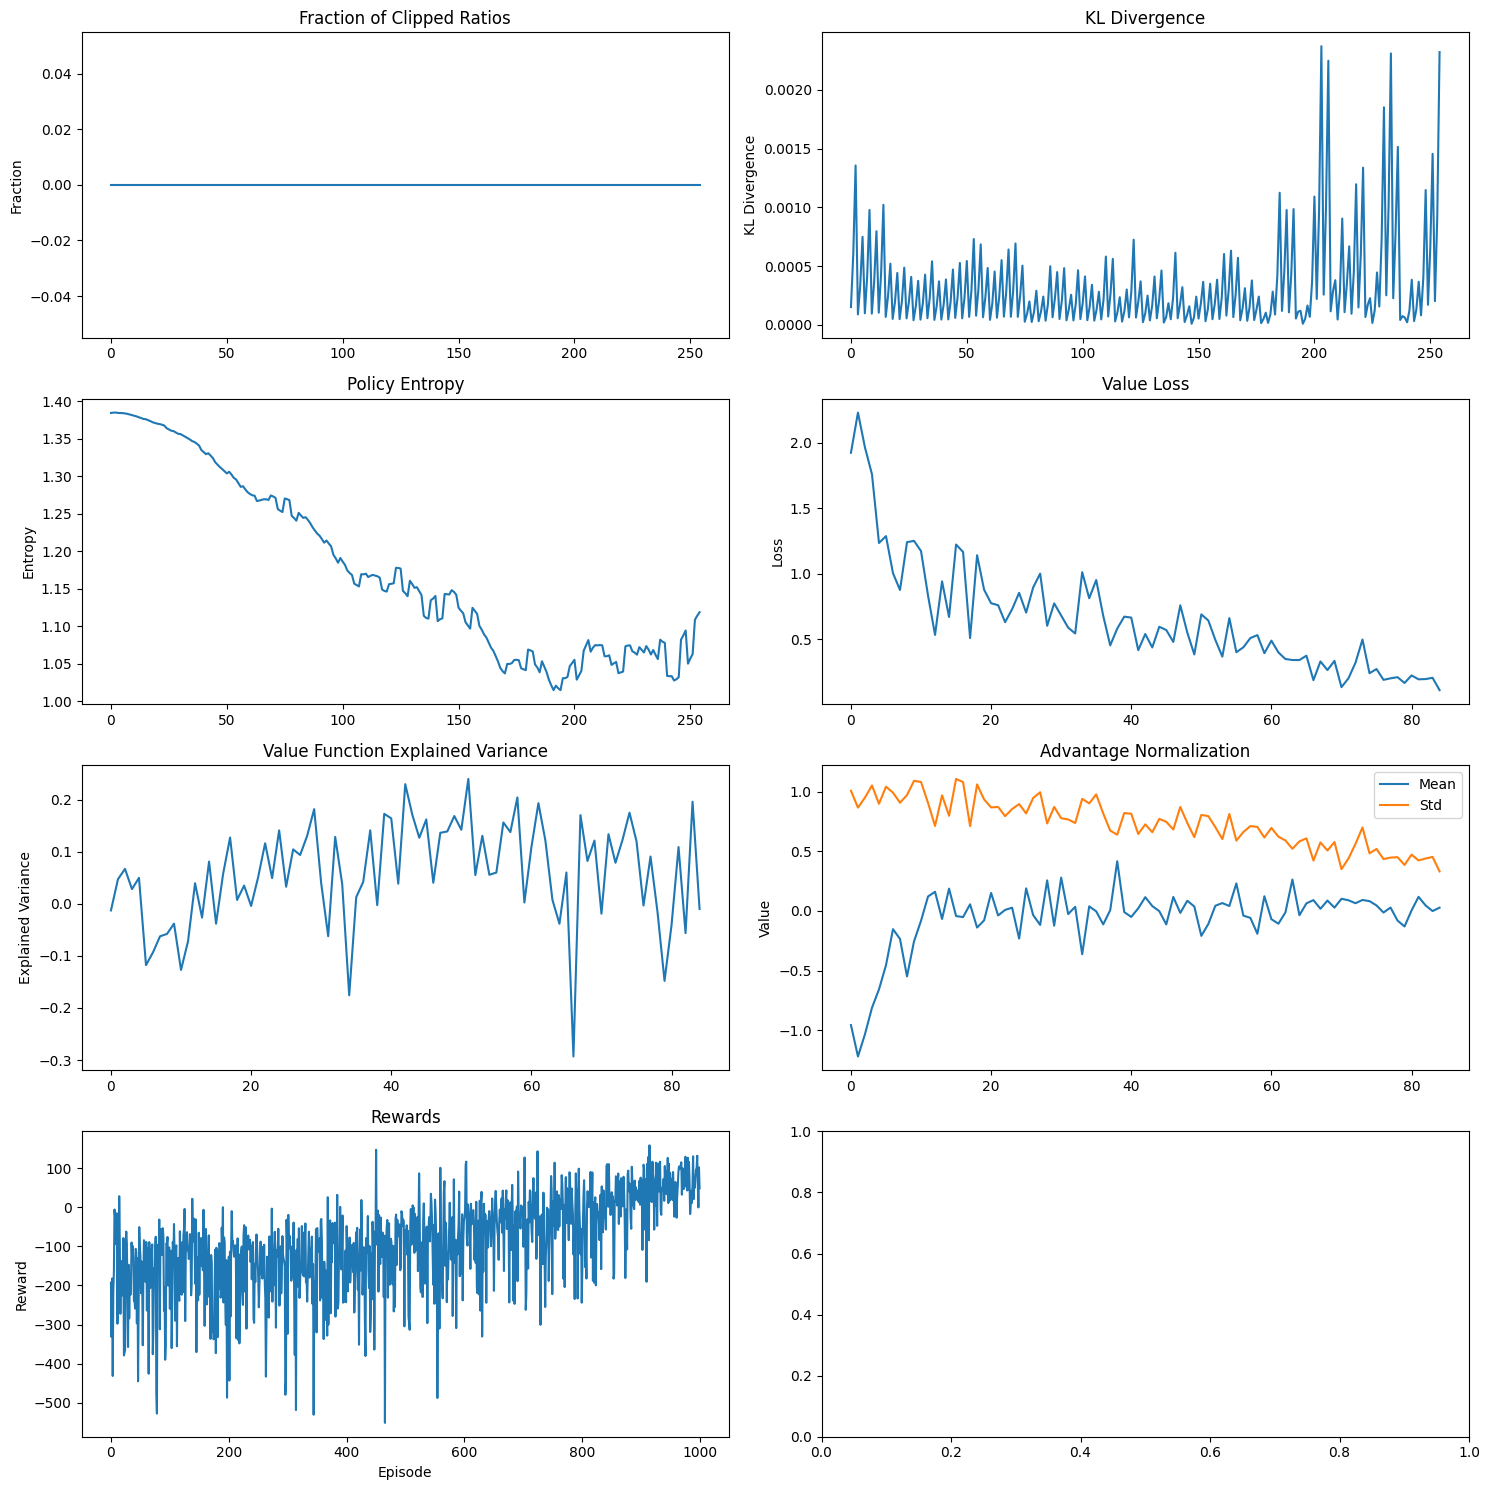

In [3]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# apply normalization as in the paper
class RunningStatistics:
    def __init__(self):
        self.n = 0
        self.mean = 0
        self.M2 = 0

    def add(self, x):
        self.n += 1
        delta = x - self.mean
        self.mean += delta / self.n
        delta2 = x - self.mean
        self.M2 += delta * delta2

    def variance(self):
        return self.M2 / (self.n - 1) if self.n > 1 else float('inf')

    def std(self):
        return np.sqrt(self.variance())

class ActorCritic(nn.Module): # Follows architecture of PPO algorithms paper
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, action_dim),
            nn.Softmax(dim=-1) # Discret
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, state):
        policy_dist = self.actor(state)
        value = self.critic(state)
        return policy_dist, value

    def evaluate(self, state, action):
        policy_dist, value = self.forward(state)
        dist = torch.distributions.Categorical(policy_dist)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        return action_logprobs, torch.squeeze(value), dist_entropy, dist

class PPOAgent:
    def __init__(self, state_dim, action_dim, lr=5e-4, gamma=0.999, k_epochs=3, eps_clip=0.2, gae_lambda=0.95, kl_threshold=0.01, max_episodes=1000, max_timesteps=300):
        self.gamma = gamma
        self.k_epochs = k_epochs
        self.eps_clip = eps_clip
        self.gae_lambda = gae_lambda
        self.kl_threshold = kl_threshold
        self.running_stats = RunningStatistics()

        self.policy = ActorCritic(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.scheduler = optim.lr_scheduler.PolynomialLR(self.optimizer, power=1., total_iters=max_episodes*self.k_epochs*max_timesteps)
        self.policy_old = ActorCritic(state_dim, action_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.MseLoss = nn.MSELoss()

        self.entropies = []
        self.kl_divergences = []
        self.clipped_ratios = []
        self.value_losses = []
        self.explained_variances = []
        self.adv_norm_means = []
        self.adv_norm_stds = []
        self.rewards = []

    def select_action(self, state):
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            policy_dist, _ = self.policy_old(state)
            dist = torch.distributions.Categorical(policy_dist)
            action = dist.sample()
            action_logprob = dist.log_prob(action)
        return action.item(), action_logprob.item()

    def update(self, memory):

        states = torch.FloatTensor(memory.states).to(device)
        actions = torch.LongTensor(memory.actions).to(device)
        rewards = torch.FloatTensor(memory.rewards).to(device)
        is_terminals = torch.FloatTensor(memory.is_terminals).to(device)
        logprobs = torch.FloatTensor(memory.logprobs).to(device)

        discounted_rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(rewards), reversed(is_terminals)):
            if is_terminal:
                discounted_reward = 0
            # Computation of rewards discounted
            discounted_reward = reward + (self.gae_lambda * self.gamma * discounted_reward)
            discounted_rewards.insert(0, discounted_reward)
            self.running_stats.add(discounted_reward)

        discounted_rewards = torch.tensor(discounted_rewards).to(device)
        discounted_rewards = discounted_rewards / (self.running_stats.std() + 1e-5)

        old_states = states
        old_actions = actions
        old_logprobs = logprobs
        rewards = discounted_rewards

        for ep in range(self.k_epochs):
            logprobs, state_values, dist_entropy, dist = self.policy.evaluate(old_states, old_actions)
            state_values = state_values.squeeze()

            advantages = rewards - state_values.detach()
            advantages_mean = advantages.mean()
            advantages_std = advantages.std()
            advantages = (advantages - advantages_mean) / (advantages_std + 1e-5)

            ratios = torch.exp(logprobs - old_logprobs.detach())
            clipped_ratios = torch.sum(torch.where(ratios > (1 + self.eps_clip), 1, 0) + torch.where(ratios < (1 - self.eps_clip), 1, 0))
            clipped_ratios_fraction = clipped_ratios / old_states.size(0)
            self.clipped_ratios.append(clipped_ratios_fraction.item())

            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages

            # combination of the three losses, including clip (PPO algo paper)
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy

            # optimize the policy grad
            self.optimizer.zero_grad()
            loss.mean().backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
            self.optimizer.step()
            # scheduler to let lr stable
            self.scheduler.step()

            with torch.no_grad():
                new_policy_dist, _ = self.policy(old_states)
                new_dist = torch.distributions.Categorical(new_policy_dist)
                logratio = new_dist.log_prob(old_actions) - old_logprobs
                ratio = torch.exp(logratio)
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()

                self.kl_divergences.append(approx_kl.item())
                self.entropies.append(dist_entropy.mean().item())

            # stop if kl is too big
            if approx_kl > self.kl_threshold:
                print(f"Early stopping at epoch {ep} due to KL divergence {approx_kl}")
                break

        self.policy_old.load_state_dict(self.policy.state_dict())

        value_loss = self.MseLoss(state_values, rewards).item()
        self.value_losses.append(value_loss)

        explained_variance = 1 - torch.var(rewards - state_values) / torch.var(rewards)
        self.explained_variances.append(explained_variance.item())

        self.adv_norm_means.append(advantages_mean.item())
        self.adv_norm_stds.append(advantages_std.item())

    def save(self, path):
        torch.save(self.policy.state_dict(), path)

    def load(self, path):
        self.policy.load_state_dict(torch.load(path))

class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

def plot_diagnostics(agent, rewards, max_episodes):
    fig, axs = plt.subplots(4, 2, figsize=(15, 15))

    axs[0, 0].plot(agent.clipped_ratios)
    axs[0, 0].set_title('Fraction of Clipped Ratios')
    axs[0, 0].set_ylabel('Fraction')

    axs[0, 1].plot(agent.kl_divergences)
    axs[0, 1].set_title('KL Divergence')
    axs[0, 1].set_ylabel('KL Divergence')

    axs[1, 0].plot(agent.entropies)
    axs[1, 0].set_title('Policy Entropy')
    axs[1, 0].set_ylabel('Entropy')

    axs[1, 1].plot(agent.value_losses)
    axs[1, 1].set_title('Value Loss')
    axs[1, 1].set_ylabel('Loss')

    axs[2, 0].plot(agent.explained_variances)
    axs[2, 0].set_title('Value Function Explained Variance')
    axs[2, 0].set_ylabel('Explained Variance')

    axs[2, 1].plot(agent.adv_norm_means, label='Mean')
    axs[2, 1].plot(agent.adv_norm_stds, label='Std')
    axs[2, 1].set_title('Advantage Normalization')
    axs[2, 1].set_ylabel('Value')
    axs[2, 1].legend()

    axs[3, 0].plot(rewards)
    axs[3, 0].set_title('Rewards')
    axs[3, 0].set_ylabel('Reward')
    axs[3, 0].set_xlabel('Episode')

    fig.tight_layout()
    plt.show()

def main(is_train=False):
    random_seed = 42
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

    torch.backends.cudnn.deterministic = True
    env = gym.make('LunarLander-v2', render_mode='rgb_array')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    memory = Memory()
    max_episodes = 1000
    max_timesteps = 300
    ppo = PPOAgent(state_dim, action_dim, max_episodes=max_episodes, max_timesteps=max_timesteps)

    update_timestep = 2000
    log_interval = 20
    save_path = "ppo_lunar_lander.pth"

    # Record the last 2 videos
    env = RecordVideo(env, video_folder="Final_Recorded_Videos2", episode_trigger=lambda x: x > (max_episodes - 3), name_prefix="video")

    def train(env, ppo, memory, max_episodes, max_timesteps, update_timestep, log_interval, save_path):
        timestep = 0
        running_reward = 0
        avg_length = 0

        all_lengths = []
        all_rewards = []

        for i_episode in range(1, max_episodes + 1):
            state, _ = env.reset()
            if i_episode == max_episodes:
                env.start_video_recorder()

            episode_reward = 0

            for t in range(max_timesteps):
                timestep += 1
                action, logprob = ppo.select_action(state)
                next_state, reward, done, _, _ = env.step(action)

                memory.states.append(state)
                memory.actions.append(action)
                memory.logprobs.append(logprob)
                memory.rewards.append(reward)
                memory.is_terminals.append(done)

                state = next_state
                running_reward += reward
                episode_reward += reward

                if timestep % update_timestep == 0:
                    ppo.update(memory)
                    memory.clear_memory()
                    timestep = 0

                if done:
                    break

            avg_length += t
            all_lengths.append(t)
            all_rewards.append(episode_reward)

            if i_episode % log_interval == 0:
                avg_length = int(avg_length / log_interval)
                running_reward = int((running_reward / log_interval))
                print(f'Episode {i_episode} \t Avg length: {avg_length} \t Avg reward: {running_reward}')
                running_reward = 0
                avg_length = 0

            if i_episode == max_episodes:
                env.close_video_recorder()

        env.close()
        print("Videos saved.")
        print(f'Overall average length: {np.mean(all_lengths)}')
        print(f'Overall average reward: {np.mean(all_rewards)}')

        plot_diagnostics(ppo, all_rewards, max_episodes)

    train(env, ppo, memory, max_episodes, max_timesteps, update_timestep, log_interval, save_path)
    env.close()

if __name__ == "__main__":
    main()


As shown in the graphs, the Rewards tend to increase with more runnings. The value functiton explained variance tends to be posiive, and the mean of advantage normalization is close to 0. The Fraction of clipped ratios is small (not 0), and the KL divergence presents some peaks, even tunning the learning rate to a scheduler.



# PROCGEN



In [4]:
! pip install procgen


In [6]:
# import
import procgen
import gym
from procgen import ProcgenEnv


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from procgen import ProcgenEnv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class RunningStatistics:
    def __init__(self):
        self.n = 0
        self.mean = 0
        self.M2 = 0

    def add(self, x):
        self.n += 1
        delta = x - self.mean
        self.mean += delta / self.n
        delta2 = x - self.mean
        self.M2 += delta * delta2

    def variance(self):
        return self.M2 / (self.n - 1) if self.n > 1 else float('inf')

    def std(self):
        return np.sqrt(self.variance())

class ActorCritic(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(ActorCritic, self).__init__()
        self.conv1 = nn.Conv2d(input_shape, 32, 8, 4)
        self.conv2 = nn.Conv2d(32, 64, 4, 2)
        self.conv3 = nn.Conv2d(64, 64, 3, 1)
        self.fc = nn.Linear(64 * 7 * 7, 256)
        self.actor = nn.Sequential(
            self.fc,
            nn.Tanh(),
            nn.Linear(256, num_actions),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            self.fc,
            nn.Tanh(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        policy_dist = self.actor(x)
        value = self.critic(x)
        return policy_dist, value

    def evaluate(self, x, action):
        policy_dist, value = self.forward(x)
        dist = torch.distributions.Categorical(policy_dist)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        return action_logprobs, torch.squeeze(value), dist_entropy, dist
class PPOAgent:
    def __init__(self, state_dim, action_dim, lr=5e-4, gamma=0.999, k_epochs=3, eps_clip=0.2, gae_lambda=0.95, kl_threshold=0.01, max_episodes=1000, max_timesteps=300):
        self.gamma = gamma
        self.k_epochs = k_epochs
        self.eps_clip = eps_clip
        self.gae_lambda = gae_lambda
        self.kl_threshold = kl_threshold
        self.running_stats = RunningStatistics()

        self.policy = ActorCritic(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.scheduler = optim.lr_scheduler.PolynomialLR(self.optimizer, power=1., total_iters=max_episodes * self.k_epochs * max_timesteps)
        self.policy_old = ActorCritic(state_dim, action_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.MseLoss = nn.MSELoss()

        self.entropies = []
        self.kl_divergences = []
        self.clipped_ratios = []
        self.value_losses = []
        self.explained_variances = []
        self.adv_norm_means = []
        self.adv_norm_stds = []
        self.rewards = []

    def select_action(self, state):
        with torch.no_grad():
            state = torch.FloatTensor(state).permute(0, 3, 1, 2).to(device) / 255.0
            policy_dist, _ = self.policy_old(state)
            dist = torch.distributions.Categorical(policy_dist)
            action = dist.sample()
            action_logprob = dist.log_prob(action)
        return action.item(), action_logprob.item()

    def update(self, memory):
        states = torch.FloatTensor(memory.states).permute(0, 3, 1, 2).to(device) / 255.0
        actions = torch.LongTensor(memory.actions).to(device)
        rewards = torch.FloatTensor(memory.rewards).to(device)
        is_terminals = torch.FloatTensor(memory.is_terminals).to(device)
        logprobs = torch.FloatTensor(memory.logprobs).to(device)

        discounted_rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(rewards), reversed(is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gae_lambda * self.gamma * discounted_reward)
            discounted_rewards.insert(0, discounted_reward)
            self.running_stats.add(discounted_reward)

        discounted_rewards = torch.tensor(discounted_rewards).to(device)
        discounted_rewards = discounted_rewards / (self.running_stats.std() + 1e-5)

        old_states = states
        old_actions = actions
        old_logprobs = logprobs
        rewards = discounted_rewards

        for ep in range(self.k_epochs):
            logprobs, state_values, dist_entropy, dist = self.policy.evaluate(old_states, old_actions)
            state_values = state_values.squeeze()

            advantages = rewards - state_values.detach()
            advantages_mean = advantages.mean()
            advantages_std = advantages.std()
            advantages = (advantages - advantages_mean) / (advantages_std + 1e-5)

            ratios = torch.exp(logprobs - old_logprobs.detach())
            clipped_ratios = torch.sum(torch.where(ratios > (1 + self.eps_clip), 1, 0) + torch.where(ratios < (1 - self.eps_clip), 1, 0))
            clipped_ratios_fraction = clipped_ratios / old_states.size(0)
            self.clipped_ratios.append(clipped_ratios_fraction.item())

            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages

            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy

            self.optimizer.zero_grad()
            loss.mean().backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
            self.optimizer.step()
            self.scheduler.step()

            with torch.no_grad():
                new_policy_dist, _ = self.policy(old_states)
                new_dist = torch.distributions.Categorical(new_policy_dist)
                logratio = new_dist.log_prob(old_actions) - old_logprobs
                ratio = torch.exp(logratio)
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()

                self.kl_divergences.append(approx_kl.item())
                self.entropies.append(dist_entropy.mean().item())

            if approx_kl > self.kl_threshold:
                print(f"Early stopping at epoch {ep} due to KL divergence {approx_kl}")
                break

        self.policy_old.load_state_dict(self.policy.state_dict())

        value_loss = self.MseLoss(state_values, rewards).item()
        self.value_losses.append(value_loss)

        explained_variance = 1 - torch.var(rewards - state_values) / torch.var(rewards)
        self.explained_variances.append(explained_variance.item())

        self.adv_norm_means.append(advantages_mean.item())
        self.adv_norm_stds.append(advantages_std.item())

    def save(self, path):
        torch.save(self.policy.state_dict(), path)

    def load(self, path):
        self.policy.load_state_dict(torch.load(path))

class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

def plot_diagnostics(agent, rewards, max_episodes):
    fig, axs = plt.subplots(4, 2, figsize=(15, 15))

    axs[0, 0].plot(agent.clipped_ratios)
    axs[0, 0].set_title('Fraction of Clipped Ratios')
    axs[0, 0].set_ylabel('Fraction')

    axs[0, 1].plot(agent.kl_divergences)
    axs[0, 1].set_title('KL Divergence')
    axs[0, 1].set_ylabel('KL Divergence')

    axs[1, 0].plot(agent.entropies)
    axs[1, 0].set_title('Policy Entropy')
    axs[1, 0].set_ylabel('Entropy')

    axs[1, 1].plot(agent.value_losses)
    axs[1, 1].set_title('Value Loss')
    axs[1, 1].set_ylabel('Loss')

    axs[2, 0].plot(agent.explained_variances)
    axs[2, 0].set_title('Value Function Explained Variance')
    axs[2, 0].set_ylabel('Explained Variance')

    axs[2, 1].plot(agent.adv_norm_means, label='Mean')
    axs[2, 1].plot(agent.adv_norm_stds, label='Std')
    axs[2, 1].set_title('Advantage Normalization')
    axs[2, 1].set_ylabel('Value')
    axs[2, 1].legend()

    axs[3, 0].plot(rewards)
    axs[3, 0].set_title('Rewards')
    axs[3, 0].set_ylabel('Reward')
    axs[3, 0].set_xlabel('Episode')

    fig.tight_layout()
    plt.show()
def main():

    random_seed = 42
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

    torch.backends.cudnn.deterministic = True
    env = ProcgenEnv(num_envs=1, env_name="coinrun", num_levels=1, start_level=0, distribution_mode="easy", render_mode="rgb_array")

    env = ProcgenEnv(num_envs=1, env_name="coinrun")
    obs = env.reset()

    # 'rgb' key from the observation DICT
    obs = obs['rgb']
    state_dim = obs.shape[1:]
    action_dim = env.action_space.n

    memory = Memory()
    max_episodes = 1000
    max_timesteps = 300
    ppo = PPOAgent(state_dim, action_dim, max_episodes=max_episodes, max_timesteps=max_timesteps)

    update_timestep = 2000
    log_interval = 20
    save_path = "ppo_coinrun.pth"

    def train(env, ppo, memory, max_episodes, max_timesteps, update_timestep, log_interval, save_path):
        timestep = 0
        running_reward = 0
        avg_length = 0

        all_lengths = []
        all_rewards = []

        for i_episode in range(1, max_episodes + 1):
            state = env.reset()
            episode_reward = 0

            for t in range(max_timesteps):
                timestep += 1
                action, logprob = ppo.select_action(state)
                next_state, reward, done, _ = env.step(action)

                memory.states.append(state)
                memory.actions.append(action)
                memory.logprobs.append(logprob)
                memory.rewards.append(reward)
                memory.is_terminals.append(done)

                state = next_state
                running_reward += reward
                episode_reward += reward

                if timestep % update_timestep == 0:
                    ppo.update(memory)
                    memory.clear_memory()
                    timestep = 0

                if done:
                    break

            avg_length += t
            all_lengths.append(t)
            all_rewards.append(episode_reward)

            if i_episode % log_interval == 0:
                avg_length = int(avg_length / log_interval)
                running_reward = int((running_reward / log_interval))
                print(f'Episode {i_episode} \t Avg length: {avg_length} \t Avg reward: {running_reward}')
                running_reward = 0
                avg_length = 0

        print(f'Overall average length: {np.mean(all_lengths)}')
        print(f'Overall average reward: {np.mean(all_rewards)}')

        plot_diagnostics(ppo, all_rewards, max_episodes)

    train(env, ppo, memory, max_episodes, max_timesteps, update_timestep, log_interval, save_path)

if __name__ == "__main__":
    main()


cpu


TypeError: unsupported operand type(s) for %: 'tuple' and 'int'